In [187]:
from LensCalcPy.survey import *
from LensCalcPy.ffp import *
from LensCalcPy.utils import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d, interp2d
from scipy.integrate import quad, nquad
from tqdm import tqdm
from pathos.multiprocessing import ProcessingPool as Pool
import functools
from scipy.stats import poisson
import seaborn as sns
sns.set_palette("colorblind")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [122]:
plt.style.use("style.mplstyle")
sns.set_palette("colorblind")

In [67]:
ti = 0.07
tf = 3
from LensCalcPy.parameters import *

In [68]:
def scientific_format(x):
    s = "%.1e" % x
    mantissa, exponent = s.split("e")
    return r"${} \times 10^{{{}}}$".format(mantissa, int(exponent))

def scientific_format_less(x):
    s = "%.1e" % x
    mantissa, exponent = s.split("e")
    return r"$10^{{{}}}$".format(int(exponent))

In [69]:
#Fig 18 of https://arxiv.org/pdf/1701.02151.pdf
mag_arr = [26, 25, 24, 23, 22, 17.5]
efficiency_arr = [0.25, 0.37, 0.62, 0.76, 0.81, 0.81]
# efficiency_dict = {26: 0.25, 25: 0.37, 24: 0.62, 23: 0.76, 22: 0.81}
efficiency_interp = interp1d(mag_arr, efficiency_arr, kind='linear')


In [70]:
#Efficiency Calculation
#Fig 22 panel 2 of https://arxiv.org/pdf/1701.02151.pdf
df = pd.read_csv('mag_distribution_hsc.csv', header=None)
magnitudes = df[0]
weights = df[1]

In [71]:
weighted_avg_efficiency = sum(efficiency_interp(magnitudes) * weights) / sum(weights)
weighted_avg_efficiency

0.7027670115593059

In [72]:
s = Survey(l, b, source_dist = ds, obs_time = obs_time, cadence = cadence, survey_area=survey_area, n_sources=n_sources, efficiency=weighted_avg_efficiency)
s

Survey(l=121.2, b=-21.6, source_dist=770, obs_time=7, cadence = 0.035, survey_area=1.767144375, n_sources=87000000.0, efficiency=0.7027670115593059)

Line of Sight

/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/LensCalcPy/galaxy.py:200: RuntimeWarning: divide by zero encountered in double_scalars
  return rhocM31 / ((r/rsM31) * (1 + r/rsM31)**2)


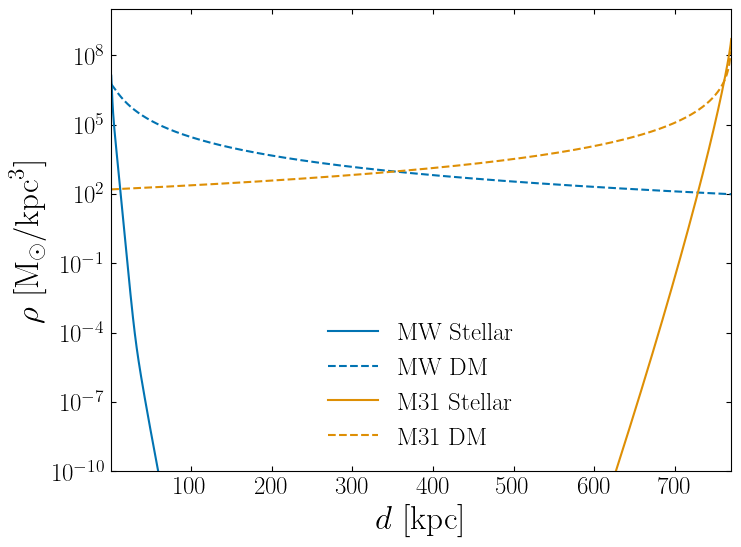

In [73]:
# Calculate the density values for each component using the methods from the classes
d_arr = np.linspace(1, ds, num=1000)

rho_ffp_mw = [s.mw_model.density_stars(d) for d in d_arr]
rho_ffp_m31 = [s.m31_model.density_stars(d) for d in d_arr]
rho_dm_mw = [s.mw_model.density_dm(d) for d in d_arr]
rho_dm_m31 = [s.m31_model.density_dm(d) for d in d_arr] # Assuming you have a method density_dm in M31Model

plt.plot(d_arr, rho_ffp_mw, label="MW Stellar")
plt.plot(d_arr, rho_dm_mw, label="MW DM", linestyle="--", color="C0")
plt.plot(d_arr, rho_ffp_m31, label="M31 Stellar")
plt.plot(d_arr, rho_dm_m31, label="M31 DM", linestyle="--", color="C1")

plt.xlabel(r"$d$ [kpc]")
plt.ylabel(r"$\rho$ [M$_\odot$/$\mathrm{kpc}^3$]")
# plt.title(r'LoS: l = ${}^\circ$, b = ${}^\circ$'.format(l, b), fontsize=16)

plt.legend()

plt.yscale("log")
plt.xlim(1e0, ds)
plt.ylim(1e-10, 1e10)
# plt.tight_layout()
# plt.savefig("figures/line_of_sight.pdf")

plt.show()

In [74]:
# Define Time Array
t_es = np.logspace(-2, 1, 30) #hours

In [75]:
#Power law index
p = 1
s.add_ffp(p)

In [76]:
def get_n_events(p=1, finite=True):
    #Now A is number of FFPs per star
    s.add_ffp(p)
    diff_rates = s.get_crossing_times_rates_ffp(t_es, finite=finite)
    rate_interp = interp1d(t_es, diff_rates)
    dnds = quad(rate_interp, ti, tf)[0]
    return s.n_sources*s.efficiency*dnds*s.obs_time

def get_n_events_parallel(p=1, finite=True):
    with Pool() as p:
        f = functools.partial(get_n_events, p=p, finite=finite)
        results = list(p.imap(f))
    return results

## Plots

In [77]:
#Define range of parameters to consider
num_points = 20
p_min = 0.5
p_max = 1.5
p_values = np.linspace(p_min, p_max, num_points) 

In [78]:
M_sun = 1.99e30
M_earth = 5.97e24
M_EARTH = M_earth/M_sun # Earth mass in solar masses

def get_constraint_dex(m_iso, p=1, finite=True):
    if m_iso < 10**(-14.5):
        raise ValueError('Mass must be greater than 10**(-14.5)')
    
    #Number of total events assuming 1 total per star
    #Note Z doesn't matter for this part of the calculation
    n_events = get_n_events(p=p, finite=finite)
    s.add_ffp(p)

    #New normalization for Z such that \Gamma * t_obs = 4.74
    Z = 4.74/n_events

    # Normalization check
    if abs(1 - nquad(s.ffp.mass_func,[[np.log10(s.ffp.m_min), np.log10(s.ffp.m_max)]], opts={'points': [np.log10(1e-15), np.log10(1e-15*1e3)]})[0]) > 1e-2:
        raise ValueError('Normalization of mass function is off by more than 1e-2')

    #Porportion of ISOs within threshold
    N_ffp_dex = Z * nquad(s.ffp.mass_func,[[np.log10(m_iso)-0.5,np.log10(m_iso)+0.5]], opts={'points': [np.log10(1e-15), np.log10(1e-15*1e3)]})[0]

    #Maximum number of allowed ISOs per star of mass m_iso or above
    return N_ffp_dex

In [79]:
get_constraint_dex(3e-6, p=0.9, finite=True)

21966.483744242683

In [80]:
confidence_level_threshold = 0.05

#initialize variable Nexp
Nexp = 1
#number of observed events
n_events = 1

# Calculate the cumulative probability until it exceeds the threshold
while True:
    # cumulative_prob = poisson.pmf(0, Nexp) + poisson.pmf(1, Nexp) 
    cumulative_prob = 0
    for i in range(n_events+1):
        cumulative_prob += poisson.pmf(i, Nexp)

    # cumulative_prob = poisson.pmf(1, Nexp) 
    if cumulative_prob <= confidence_level_threshold:
        break
    Nexp += 0.01 

print(f"The 95% C.L. is reached when Nexp <= {Nexp}")

The 95% C.L. is reached when Nexp <= 4.749999999999942


### Constraints on local ISO Density

In [135]:
def get_n_events_pbh(m, finite=True):
    s.add_pbh(m)
    diff_rates = s.get_crossing_times_rates_pbh(t_es, finite=finite)
    rate_interp = interp1d(t_es, diff_rates)
    dnds = quad(rate_interp, ti, tf)[0]
    return s.n_sources*s.efficiency*dnds*s.obs_time

def get_constraint_fdm(m, finite=True):
    n_events = get_n_events_pbh(m, finite=finite)
    if n_events != 0:
        return 4.74/n_events
    else:
        return 1

def get_constraint_fdm_parallel(m_pbhs, finite=False):
    with Pool() as p:
        f = functools.partial(get_constraint_fdm, finite=finite)
        # results = list(p.imap(f, m_pbhs))
        results = list(tqdm(p.imap(f, m_pbhs), total=len(m_pbhs)))

    return results

In [82]:
#https://arxiv.org/pdf/1910.08608.pdf handwavy constraint in au^-3

local_dm_density = density_mw(dist_mw(0))
m_pbh = 1e-10
fpbh = get_constraint_fdm(m_pbh, finite=True)
kpc2au = 2.06e8

print("upper limit on number density of ISOs in au^-3 from HSC PBH constrint")
print(local_dm_density*kpc2au**(-3)*fpbh/m_pbh)

/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


upper limit on number density of ISOs in au^-3 from HSC PBH constrint
3.170647241835771e-11


### Power law plots

In [83]:
#Pg 10 of https://arxiv.org/pdf/1910.08608.pdf
dohanyi_alpha = 2.5
dohanyi_p = dohanyi_alpha/3 
dohanyi_n = 7.2e-11

MOA_Z = 2.18
MOA_p = 0.96
KMT_Z = 0.4
KMT_p = 0.92

N_MOA = quad(lambda x: MOA_Z*(10**x/8)**(-MOA_p), np.log10(0.33), np.log10(6660))[0]
N_KMT = quad(lambda x: KMT_Z*(10**x/38)**(-KMT_p), np.log10(0.33), np.log10(6660))[0]

print(N_MOA)
print(N_KMT)

21.04411106964539
14.872261024601801


In [84]:
def get_power_law(p, finite=True):
    n_events = get_n_events(p=p, finite=finite)
    s.add_ffp(p)

    #New normalization for Z such that \Gamma * t_obs = 4.74
    Z = 4.74/n_events * s.ffp.Z

    m_norm = s.ffp.M_norm

    return Z, m_norm

In [85]:
z_133, m_norm_133 = get_power_law(p=1.33)

In [86]:
z_066, m_norm_066 = get_power_law(p=0.66)

In [87]:
def dN_dlogM(Z, M, M_norm, p):
    return Z * (M/M_norm)**-p

In [88]:
M_arr1 = np.logspace(-6, -3, 100)
M_arr2 = np.logspace(-24, -20, 100)
M_arr3 = np.logspace(-24, -3, 100)

dN_dlogM_arr_MOA = np.array([dN_dlogM(2.18, M, 3e-6*8, 0.96-0.27) for M in M_arr1])
dN_dlogM_arr_MOA2 = np.array([dN_dlogM(2.18, M, 3e-6*8, 0.96+0.47) for M in M_arr1])

dN_dlogM_arr_KMT = np.array([dN_dlogM(0.4, M, 3e-6*38, 0.9) for M in M_arr1])
dN_dlogM_arr_KMT2 = np.array([dN_dlogM(0.4, M, 3e-6*38, 1.2) for M in M_arr1])

dN_dlogM_arr_Do = np.array([dN_dlogM(3.3e16, M, 3e-17 * 3e-6, 0.66) for M in M_arr2])
dN_dlogM_arr_Do2 = np.array([dN_dlogM(3.3e16, M, 3e-17 * 3e-6, 1.33) for M in M_arr2])

dN_dlogM_arr_Do = np.array([dN_dlogM(3.3e16, M, 3e-17 * 3e-6, 0.92-0.06) for M in M_arr2])
dN_dlogM_arr_Do2 = np.array([dN_dlogM(3.3e16, M, 3e-17 * 3e-6, 0.92+0.06) for M in M_arr2])

dN_dlogM_arr_fit = np.array([dN_dlogM(0.4, M, 3e-6*38, 0.92) for M in M_arr3])
dN_dlogM_arr_fiducial = np.array([dN_dlogM(10, M, M_EARTH, 1) for M in M_arr3])

dN_dlogM_arr_ours = np.array([dN_dlogM(z_133, M, m_norm_133, 1.33) for M in M_arr3])
dN_dlogM_arr_ours2 = np.array([dN_dlogM(z_066, M, m_norm_066, 0.66) for M in M_arr3])

do_idx = np.where(abs(dN_dlogM_arr_Do-dN_dlogM_arr_Do2) == min(abs(dN_dlogM_arr_Do-dN_dlogM_arr_Do2)))[0][0]
kmt_idx = np.where(abs(dN_dlogM_arr_KMT-dN_dlogM_arr_KMT2) == min(abs(dN_dlogM_arr_KMT-dN_dlogM_arr_KMT2)))[0][0]
moa_idx = np.where(abs(dN_dlogM_arr_MOA-dN_dlogM_arr_MOA2) == min(abs(dN_dlogM_arr_MOA-dN_dlogM_arr_MOA2)))[0][0]

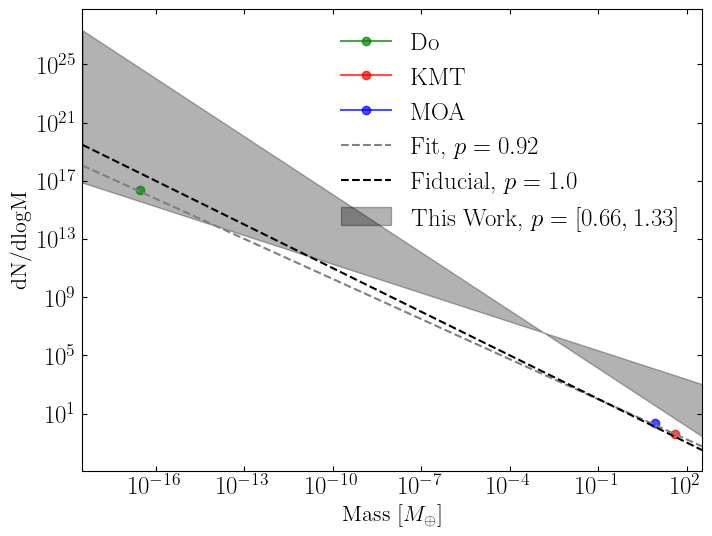

In [89]:
# plt.fill_between(M_arr1, dN_dlogM_arr_KMT, dN_dlogM_arr_KMT2, alpha=0.3, color='red', label='KMT, 0.9-1.2')
# plt.fill_between(M_arr1, dN_dlogM_arr_MOA, dN_dlogM_arr_MOA2, alpha=0.3, color='blue', label='MOA, 0.69 - 1.43')
# plt.fill_between(M_arr2, dN_dlogM_arr_Do, dN_dlogM_arr_Do2, alpha=0.3, color='green', label='Do, 0.66 - 1.33')

plt.plot(M_arr2[do_idx]/M_EARTH, dN_dlogM_arr_Do[do_idx]*0.7, alpha=0.7, color='green', marker='o', label='Do')
plt.plot(M_arr1[kmt_idx]/M_EARTH, dN_dlogM_arr_KMT[kmt_idx], alpha=0.7, color='red', marker='o', label='KMT')
plt.plot(M_arr1[moa_idx]/M_EARTH, dN_dlogM_arr_MOA[moa_idx], alpha=0.7, color='blue', marker='o', label='MOA')

plt.plot(M_arr3/M_EARTH, dN_dlogM_arr_fit, color='gray', label=r'Fit, $p = 0.92$', ls='--')
plt.plot(M_arr3/M_EARTH, dN_dlogM_arr_fiducial, color='black', label=r'Fiducial, $p = 1.0$', ls='--')


plt.fill_between(M_arr3/M_EARTH, dN_dlogM_arr_ours, dN_dlogM_arr_ours2, alpha=0.3, color='black', label=r'This Work, $p = [0.66, 1.33]$')

# plt.axvline(1e-9, color='black', ls='--')
# plt.axvline(1e-5, color='black', ls='--')

plt.xscale('log')
plt.yscale('log')

plt.legend()

plt.xlim(min(M_arr2)/M_EARTH, max(M_arr1)/M_EARTH)

plt.xlabel(r"Mass [$M_{\oplus}$]", fontsize=16)
plt.ylabel(r'dN/dlogM', fontsize=16)

# plt.xlim(1e-7, 1e-1)

# plt.savefig('figures/mass_function_results.pdf')

plt.show()

In [90]:
m_values = np.logspace(-10, -4, 16) #in solar masses
local_stellar_density = 0.1 * 1e9 # solar mass per cubic kpc
p_values_mass = np.array([0.66, 1, 1.33])

def get_num_density(Z, M, M_norm, p):
    '''
    Returns the number density of objects within 1 dex of M in au^-3
    '''
    M_arr = np.linspace(np.log10(M)-0.6, np.log10(M)+0.6, 100)
    dN_dlogM_arr = np.array([dN_dlogM(Z, 10**m, M_norm, p) for m in M_arr])
    interp = interp1d(M_arr, dN_dlogM_arr)
    return quad(interp, np.log10(M)-0.5, np.log10(M)+0.5)[0] * local_stellar_density * kpc2au ** (-3)

In [91]:
num_densities_MOA = np.array([get_num_density(2.18, M, 3e-6*8, 0.96) for M in m_values])
num_densities_KMT = np.array([get_num_density(0.4, M, 3e-6*38, 0.92) for M in m_values])
num_densities_Do = np.array([get_num_density(3.3e16, M, 3e-17 * 3e-6, 0.83) for M in m_values])
num_densities_Fiducial = np.array([get_num_density(10, M, 3e-6, 1) for M in m_values])


/var/folders/qd/09mj47cx551c65glw6y47d6r0000gn/T/ipykernel_58725/857666846.py:12: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(interp, np.log10(M)-0.5, np.log10(M)+0.5)[0] * local_stellar_density * kpc2au ** (-3)


In [92]:
n_objects_dict_mass = {}
for p_val in p_values_mass:
    with Pool() as p:
        f = functools.partial(get_constraint_dex, p=p_val, finite=True)
        n_objects_dict_mass[p_val] = list(tqdm(p.imap(f, m_values), total=len(m_values)))

100%|██████████| 16/16 [05:46<00:00, 21.63s/it]


In [93]:
#Constraint on 1e-2 * Earth mass objects for p = 1
get_constraint_dex(m_iso = 1e-2*M_EARTH, p=1)*local_stellar_density * kpc2au ** (-3)

1.4111867270138727e-11

In [94]:
1.3*10**(-11)*kpc2au **3 * (1e-9) #in pc^-3

113643.60800000001

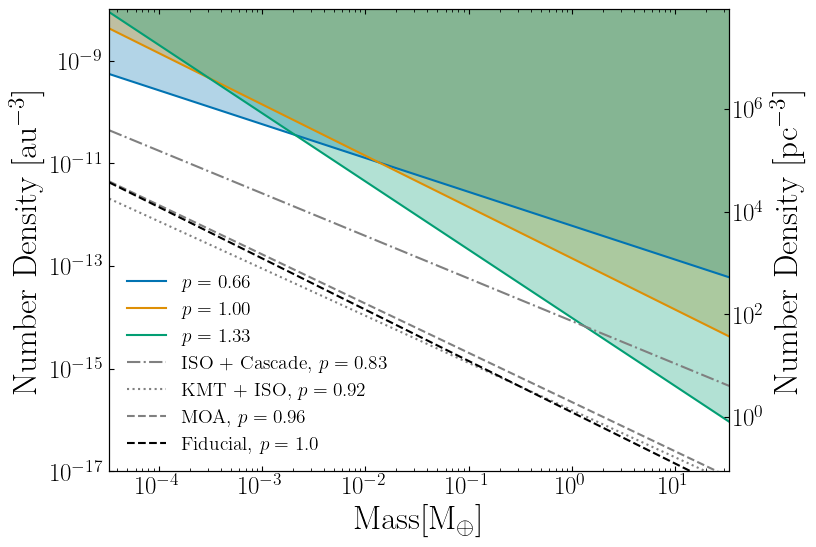

In [126]:
#! RERUN!!!
au3_to_pc3 = 1.0 / (206265.0 ** 3)

plt.figure()

# Loop over the dictionary items
for p, n_objects_arr in n_objects_dict_mass.items():
    num_densities = np.array(n_objects_arr) * local_stellar_density * kpc2au ** (-3)

    plt.plot(m_values/M_EARTH, num_densities, label=f'$p = $ {p:.2f}')
    plt.fill_between(m_values/M_EARTH, num_densities, 1, alpha=0.3)

plt.plot(m_values/M_EARTH, num_densities_Do, label='ISO + Cascade, $p = 0.83$', color='gray', linestyle='-.')
plt.plot(m_values/M_EARTH, num_densities_KMT, label='KMT + ISO, $p = 0.92$', color='gray', linestyle=':')
plt.plot(m_values/M_EARTH, num_densities_MOA, label='MOA, $p = 0.96$', color='gray', linestyle='--')
plt.plot(m_values/M_EARTH, num_densities_Fiducial, label='Fiducial, $p = 1.0$', color='black', linestyle='--')


plt.yscale('log')
plt.xscale('log')

plt.ylabel(r'Number Density [au$^{-3}$]')
plt.xlabel(r'$\rm{Mass} [ M_\oplus ]$')
# plt.title(r'Max Number Density of UBOs within 1 Dex')

plt.xlim([min(m_values)/M_EARTH, max(m_values)/M_EARTH])

#min and max number density in au^-3
ymin = 1e-17
ymax = 1e-8
plt.ylim([ymin, ymax])

plt.legend(loc='lower left', frameon=False)

plt.tick_params(axis='both', direction='in', which='both', bottom=True, top=True, left=True, right=True)

# creating a twin axis
ax2 = plt.twinx()
ax2.set_ylabel(r'Number Density [pc$^{-3}$]')

# set the same y-scale as the left side
ax2.set_yscale('log')

# convert y limit from au^-3 to pc^-3 using conversion_factor
plt.ylim([ymin/au3_to_pc3, ymax/au3_to_pc3])

# ticks on right side
ax2.tick_params(axis='y', direction='in', which='both')

# plt.savefig('figures/number_density_iso_mass.pdf')

plt.show()

### Predicted Number of Events

In [98]:
#! use fiducial mass function here
def get_num_events_fiducial():
    z, m_norm = get_power_law(p=1)
    # convert normalization to earth mass to compare Z directly with fiducial mass function
    #dN/dlogM = 10(M/M_earth)^{-1}
    z_earth = z*(3e-6)**(-1)
    #Our Z is calculated for 4.74 expected events. Convert
    Z_fiducial = 10
    num_events_fiducial = 4.74*Z_fiducial/z_earth
    return num_events_fiducial


In [ ]:
# p_kmt_arr = np.linspace(0.9, 1.2, 10)
# num_events_kmt_arr = np.array([get_kmt_events(p) for p in p_kmt_arr])
num_events_fiducial = get_num_events_fiducial()

In [ ]:
print("Estimated number of detected UBOs for survey: {} is \n {}".format(s, scientific_format(num_events_fiducial)))

Estimated number of detected UBOs for survey: Survey(l=121.2, b=-21.6, source_dist=770, obs_time=7, survey_area=0, n_sources=87000000.0) is 
 $4.5 \times 10^{-3}$


### Naive FFP Constraints from monochromatic PBH HSC

In [99]:
df = pd.read_csv('Roman_exclusion.csv', header=None)
df.head()
roman_exclusion_interp = interp1d(df[0], df[1], kind='linear', bounds_error=False, fill_value=0)

In [141]:
m_pbhs = np.logspace(-13, -4, 50) #solar masses

# fdm_finite = get_constraint_fdm_parallel(m_pbhs, finite=True)
fdm_finite = np.array([get_constraint_fdm(m_pbh, finite=True) for m_pbh in m_pbhs])


/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  lo

In [142]:
nstar = 0.14 # per cubic parsec
rho_halo = 0.3 # GeV/cm^3
M_EARTH = 3e-6 # solar masses
M_SUN = 2e30 # kg
cm_to_pc = 3.24e-19
GeV_to_kg = 1.78e-27
GeV_to_solar_mass = GeV_to_kg / M_SUN
rho_halo_Msol_pc3 = rho_halo * GeV_to_solar_mass / cm_to_pc**3
rho_halo_Mearth_pc3 = rho_halo_Msol_pc3 / M_EARTH

f_HM = np.array(fdm_finite) / nstar * rho_halo_Msol_pc3 

ms_earth = m_pbhs/M_EARTH # convert to earth masses
f_HM_earth = f_HM/M_EARTH # convert to earth masses

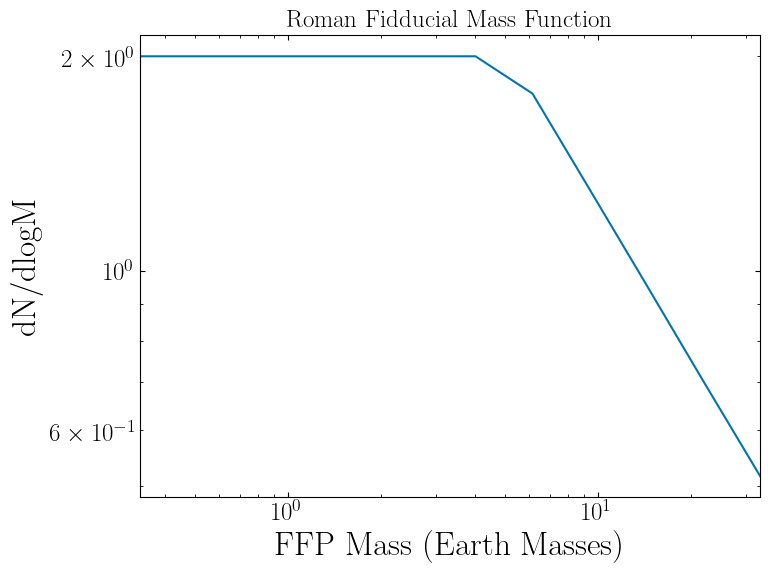

In [102]:
ms_1 = np.logspace(-16, np.log10(M_EARTH*5.2))
ms_2 = np.logspace(np.log10(M_EARTH*5.2), -1)

roman_dndlogm = np.array([2]*len(ms_1))
roman_dndlogm = np.append(roman_dndlogm, dN_dlogM(0.24, ms_2, 95*M_EARTH, 0.73))

roman_dndlogm_interp = interp1d(np.log10(np.append(ms_1, ms_2)), roman_dndlogm)

roman_dns = roman_dndlogm_interp(np.log10(m_pbhs))

plt.loglog(m_pbhs/M_EARTH, roman_dns)
plt.xlabel('FFP Mass (Earth Masses)')
plt.ylabel('dN/dlogM')
plt.title('Roman Fidducial Mass Function')

plt.xlim(1e-6/M_EARTH, 1e-4/M_EARTH)
plt.show()

In [103]:
def mass_in_ffps_dex_roman(M):
    N_ffp_roman = nquad(roman_dndlogm_interp, [[np.log10(M)-0.5,np.log10(M)+0.5]])[0]
    return N_ffp_roman*M

print(mass_in_ffps_dex_roman(3e-6))
ms_roman = np.logspace(-15, -3, 100)
m_ffps_roman = np.array([mass_in_ffps_dex_roman(m) for m in ms_roman])

6e-06


/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


In [104]:
roman_exclusion_ms = np.logspace(-4, 4, 100)
roman_exlusions = roman_exclusion_interp(roman_exclusion_ms)

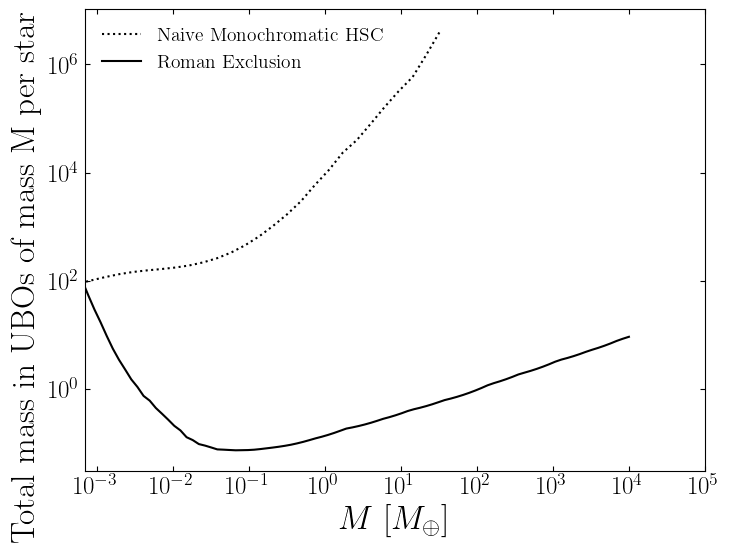

In [138]:
plt.loglog(ms_earth, f_HM_earth, 'k', ls=':', label='Naive Monochromatic HSC')
plt.loglog(roman_exclusion_ms, roman_exlusions, 'k', ls='-', label='Roman Exclusion')

plt.xlim(7e-4, 1e5)
# plt.ylim(7e-3, 1e6)

plt.xlabel(r'$M$ [$M_{\oplus}$]')
plt.ylabel('Total mass in UBOs of mass M per star [M$_{\oplus}$]')

plt.tick_params(axis='x', which='both', top=True, direction='in')
plt.tick_params(axis='y', which='both', right=True, direction='in')

# Set the tick spacing on the x-axis to be twice as dense
ax = plt.gca()
ax.xaxis.set_major_locator(plt.LogLocator(base=10.0, numticks=10))

plt.legend()

plt.show()

In [180]:
def monochromatic_rate_ffp(m, return_sep=True):
    ti = 0.07
    tf = 3
    # tf = 30

    f = Ffp(1, l=l, b=b)
    ts = np.logspace(-3, np.log10(tf), num=40)

    diff_rates_monochromatic_m31 = []
    diff_rates_monochromatic_mw = []
    for t in ts:
        diff_rates_monochromatic_m31.append(f.differential_rate_m31_monochromatic(t, finite=True, m=m))
        diff_rates_monochromatic_mw.append(f.differential_rate_mw_monochromatic(t, finite=True, m=m))
    
    diff_interp_m31 = interp1d(ts, diff_rates_monochromatic_m31)
    diff_interp_mw = interp1d(ts, diff_rates_monochromatic_mw)

    quad_m31 = quad(diff_interp_m31, ti, tf)[0]
    quad_mw = quad(diff_interp_mw, ti, tf)[0]

    if return_sep:
        return quad_mw, quad_m31
    
    return quad_mw + quad_m31


def expected_nevents_ffp_monochromatic(m):
    dnds = monochromatic_rate_ffp(m, return_sep=False)
    n_exp = s.n_sources*s.efficiency*s.obs_time*dnds
    return n_exp

In [128]:
our_N_ffp_perstar = 4.74/np.array([expected_nevents_ffp_monochromatic(m) for m in m_pbhs])
our_Mffp_perstar_earth = our_N_ffp_perstar *m_pbhs/M_EARTH # Mass of FFPs per star in earth masses

/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  lo

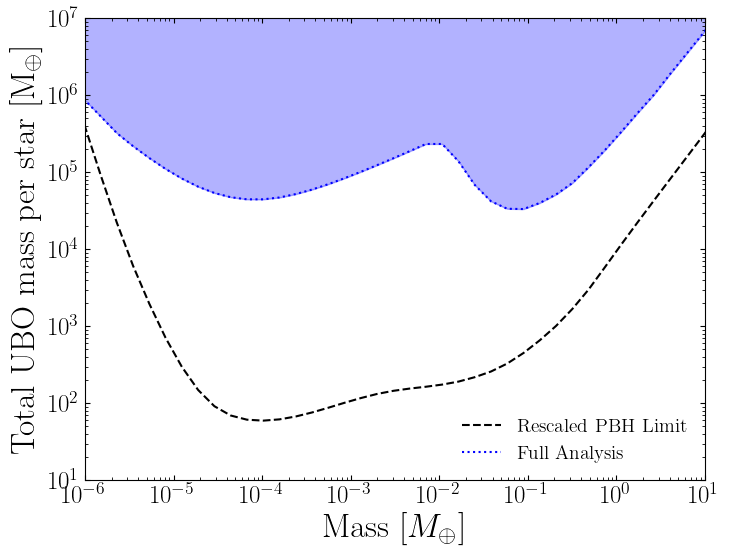

In [152]:
plt.loglog(ms_earth, f_HM_earth, 'k', ls='--', label='Rescaled PBH Limit')
plt.loglog(ms_earth, our_Mffp_perstar_earth, 'blue', ls=':', label='Full Analysis')

plt.fill_between(ms_earth, our_Mffp_perstar_earth, 1e10, alpha=0.3, color='blue')

plt.xlim(1e-6, 1e1)
plt.ylim(1e1, 1e7)

plt.xlabel(r'Mass [$M_{\oplus}$]')
plt.ylabel('Total UBO mass per star [M$_{\oplus}$]')

plt.tick_params(axis='x', which='both', top=True, direction='in')
plt.tick_params(axis='y', which='both', right=True, direction='in')

# Set the tick spacing on the x-axis to be twice as dense
ax = plt.gca()
ax.xaxis.set_major_locator(plt.LogLocator(base=10.0, numticks=10))

plt.legend(loc='lower right')

# plt.savefig('figures/monochromatic_mass.pdf')

plt.show()

### Velocity Dependence

In [155]:
p = 1.0
# p = 2.0
f = Ffp(p, l=l, b=b)
ts = np.logspace(-2, 1, num=40)
f

FFP with power law dN / dlogM ~ m^-1.0

In [157]:
diff_rates_finite_mw = []
for t in tqdm(ts, desc='Computing differential rates for MW (finite=True)'):
    diff_rates_finite_mw.append(f.differential_rate_mw(t, finite=True))
diff_rates_finite_mw = np.array(diff_rates_finite_mw)

diff_rates_finite_m31 = []
for t in tqdm(ts, desc='Computing differential rates for M31 (finite=True)'):
    diff_rates_finite_m31.append(f.differential_rate_m31(t, finite=True))
diff_rates_finite_m31 = np.array(diff_rates_finite_m31)

Computing differential rates for MW (finite=True):   0%|          | 0/40 [00:00<?, ?it/s]/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returne

In [158]:
diff_rates_finite_mw_60 = []
for t in tqdm(ts, desc='Computing differential rates for MW (finite=True)'):
    diff_rates_finite_mw_60.append(f.differential_rate_mw(t, finite=True, v_disp=60))
diff_rates_finite_mw_60 = np.array(diff_rates_finite_mw_60)

diff_rates_finite_m31_120 = []
for t in tqdm(ts, desc='Computing differential rates for M31 (finite=True)'):
    diff_rates_finite_m31_120.append(f.differential_rate_m31(t, finite=True, v_disp=120))
diff_rates_finite_m31_120 = np.array(diff_rates_finite_m31_120)

Computing differential rates for MW (finite=True): 100%|██████████| 40/40 [1:09:49<00:00, 104.75s/it]  
Computing differential rates for M31 (finite=True): 100%|██████████| 40/40 [45:39<00:00, 68.48s/it]   


In [159]:
diff_rates_finite_mw_15 = []
for t in tqdm(ts, desc='Computing differential rates for MW (finite=True)'):
    diff_rates_finite_mw_15.append(f.differential_rate_mw(t, finite=True, v_disp=15))
diff_rates_finite_mw_15 = np.array(diff_rates_finite_mw_15)

diff_rates_finite_m31_30 = []
for t in tqdm(ts, desc='Computing differential rates for M31 (finite=True)'):
    diff_rates_finite_m31_30.append(f.differential_rate_m31(t, finite=True, v_disp=30))
diff_rates_finite_m31_30 = np.array(diff_rates_finite_m31_30)

Computing differential rates for MW (finite=True): 100%|██████████| 40/40 [2:02:50<00:00, 184.26s/it]  
Computing differential rates for M31 (finite=True): 100%|██████████| 40/40 [1:02:11<00:00, 93.29s/it]


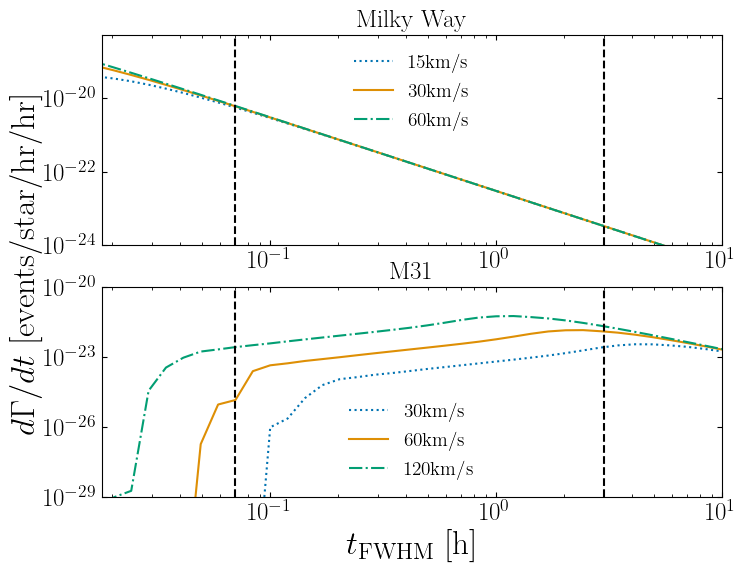

In [168]:
# Create a figure and a grid of subplots
fig, axs = plt.subplots(2)

# First subplot
axs[0].loglog(ts, diff_rates_finite_mw_15, label="15km/s", linestyle=':')
axs[0].loglog(ts, diff_rates_finite_mw, label="30km/s", linestyle='-')
axs[0].loglog(ts, diff_rates_finite_mw_60, label="60km/s", linestyle='-.')

axs[0].axvline(ti, color='black', linestyle='--')
axs[0].axvline(tf, color='black', linestyle='--')

axs[0].set_title('Milky Way')
axs[0].set_xlim(min(ts)*1.8, max(ts))
axs[0].set_ylim(1e-24,5e-19)
axs[0].legend()

# Second subplot
axs[1].loglog(ts, diff_rates_finite_m31_30, label="30km/s ", linestyle=':')
axs[1].loglog(ts, diff_rates_finite_m31, label="60km/s ", linestyle='-')
axs[1].loglog(ts, diff_rates_finite_m31_120, label="120km/s ", linestyle='-.')

axs[1].axvline(ti, color='black', linestyle='--')
axs[1].axvline(tf, color='black', linestyle='--')

axs[1].set_xlabel(r"$t_{\rm{FWHM}}$ [h]")
axs[1].set_title('M31')
axs[1].set_xlim(min(ts)*1.8, max(ts))
axs[1].set_ylim(1e-29,1e-20)
axs[1].legend()

fig.text(0.01, 0.5, r"$d\Gamma/dt$ [events/star/hr/hr]", va='center', rotation='vertical', fontsize=24)   

# plt.savefig('figures/differential_rate_velocity.pdf')
# Show plot
# plt.tight_layout()
plt.show()


In [114]:
diff_rates_finite_mw_15_interp = interp1d(ts, diff_rates_finite_mw_15)
diff_rates_finite_m31_30_interp = interp1d(ts, diff_rates_finite_m31_30)
diff_rates_finite_mw_60_interp = interp1d(ts, diff_rates_finite_mw_60)
diff_rates_finite_m31_120_interp = interp1d(ts, diff_rates_finite_m31_120)
diff_rates_mw_interp = interp1d(ts, diff_rates_finite_mw)
diff_rates_m31_interp = interp1d(ts, diff_rates_finite_m31)


rate_slow = quad(diff_rates_finite_mw_15_interp, ti, tf)[0] + quad(diff_rates_finite_m31_30_interp, ti, tf)[0]
rate_fast = quad(diff_rates_finite_mw_60_interp, ti, tf)[0] + quad(diff_rates_finite_m31_120_interp, ti, tf)[0]
rate_fiducial = quad(diff_rates_mw_interp, ti, tf)[0] + quad(diff_rates_m31_interp, ti, tf)[0]
print(rate_slow, rate_fiducial, rate_fast )

6.126197229363525e-22 8.363316385271445e-22 1.5788709845154898e-21


### Mass sensitivity

In [189]:
# m_arr = np.logspace(-10, -4, 100) #solar masses
m_arr = np.logspace(-10, -4, 50) #solar masses

p = 1
# with Pool() as pool:
#     rates  = list(tqdm(pool.imap(monochromatic_rate_ffp, m_arr), total=len(m_arr)))

rates  = [monochromatic_rate_ffp(m) for m in tqdm(m_arr)]

rates_mw = []
rates_m31 = []
for rate in rates:
    rates_mw.append(rate[0])
    rates_m31.append(rate[1])
    
rates_mw = np.array(rates_mw)
rates_m31 = np.array(rates_m31)

  0%|          | 0/50 [00:00<?, ?it/s]/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the dif

In [190]:
rates_mw_interp = interp1d(m_arr, rates_mw, kind='cubic')
rates_m31_interp = interp1d(m_arr, rates_m31, kind='cubic')
m_arr_2 = np.logspace(-10, -4, 60) #solar masses

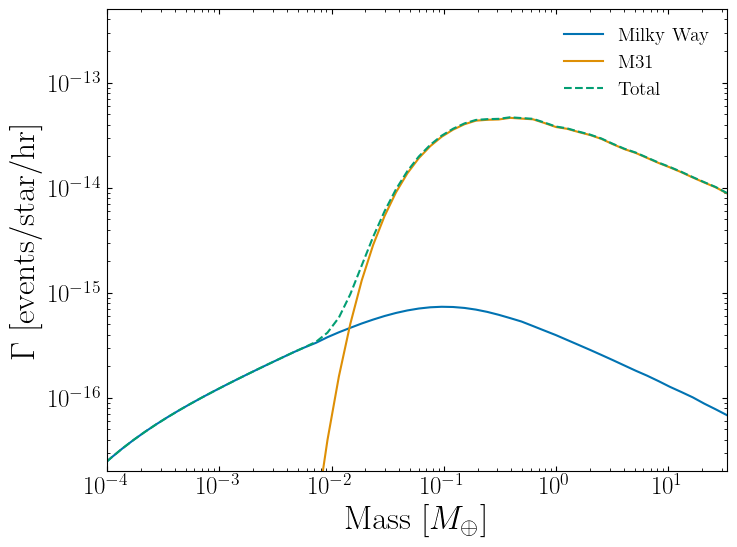

In [193]:
plt.plot(m_arr_2/M_EARTH, rates_mw_interp(m_arr_2), label='Milky Way')
plt.plot(m_arr_2/M_EARTH, rates_m31_interp(m_arr_2), label='M31')
plt.plot(m_arr_2/M_EARTH, rates_mw_interp(m_arr_2) + rates_m31_interp(m_arr_2), label='Total', ls='--')

plt.xscale('log')
plt.yscale('log')
plt.xlabel("Mass [$M_{\oplus}$]")
plt.ylabel(r"$\Gamma$ [events/star/hr]")
# plt.title("Monochromatic UBO Sensitivity")

plt.xlim(1e-4, max(m_arr_2)/M_EARTH)
plt.ylim(2e-17, 5e-13)

plt.legend()

# plt.savefig('figures/monochromatic_sensitivity.pdf')

plt.show()